In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tools.tools import EMA

emaFilter = EMA(0.85)

In [10]:

def load_csv(root):
    df = pd.read_csv(root, sep = "\t", skiprows= [0], names = ["r", "z", "dBz", "dBr"])
    #drop not needed
    df.drop(df[df["r"]>0.8e-3].index, inplace = True)
    #Flip the frame
    df["z"] = df["z"].max() - df["z"]

    return df

def closestValue(node):
    deltas = fieldArray - node
    dist = np.einsum("ij,ij->i", deltas, deltas)
    return np.argmin(dist)

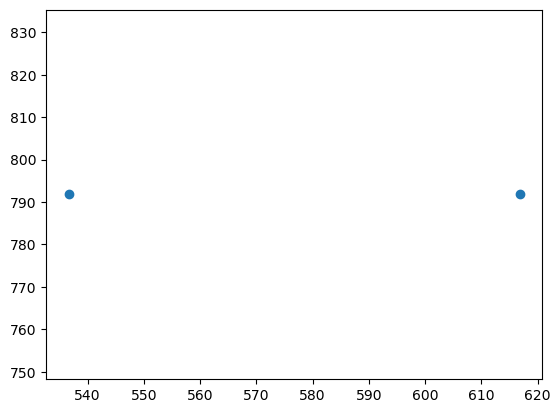

In [16]:
plt.scatter(x = np.array([616.85125643, 536.67686951]), y = np.array([791.7845897, 791.7845897]))

In [12]:
root = "C:/Users/Asentaja/Git/MicrorheologyProto/resource/gradB.csv"
past = 0
df = load_csv(root)
field = np.stack([df["r"].values,df["z"].values], axis = 1)

fieldArray =  np.asarray(field)
dBzVal = df["dBz"].values
dBrVal = df["dBr"].values

data = np.array([616.85125643,791.78458977,536.67686951,c])
x = data[0]
y = data[1]

x = emaFilter.filterNow(x)
y = emaFilter.filterNow(y)
place = np.stack([x,y])
idx = closestValue(place)
cB  = np.sqrt((dBzVal[idx])**2 + (dBzVal[idx])**2)

error = cB-past
#self.past = cB
#emitData(error)

In [141]:
import _pickle as cPickle
import scipy

from scipy.optimize import curve_fit

In [149]:
#path_calib = "./test/calib.npy"
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"
path_track = "./test/trackingData.pickle"

#file_calib = np.load(path_calib)
file_driver = np.load(path_driver)
file_frame = np.load(path_frame)

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

In [150]:
df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])
df_track = pd.DataFrame.from_dict(file_track)

df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] =df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40

Kelvin-Voigt:
 D:  [2.40656594e-04 9.71262479e-06] 
tau:  [0.0305788  0.00024066]
Maxwell relaxation:
 D:  [ -3.45755962 397.54143237] 
tau:  [ 0.030279   -3.45755962]


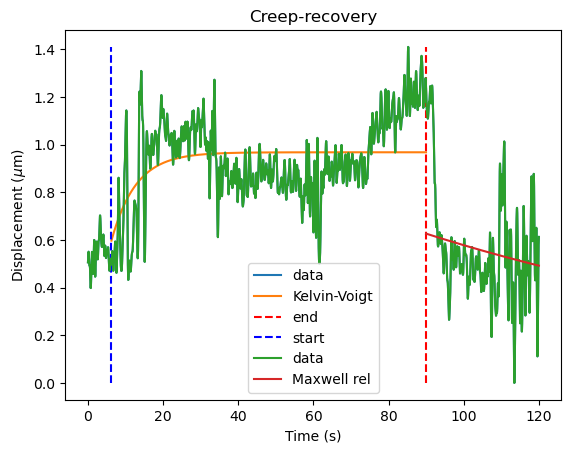

In [180]:
rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)

p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep], df_track["distance"][start_creep:end_creep], method = "dogbox")
plt.plot(t_hat, kelvin(t_hat,*p), label = "Kelvin-Voigt")

print("Kelvin-Voigt:\n D: ", p_[1], "\ntau: ", p_[0] )

#p, p_ = curve_fit(maxwell, df_track["time"][start_creep:end_creep], df_track["distance"][start_creep:end_creep], method = "dogbox")
#plt.plot(t_hat, maxwell(t_hat,*p), label = "Maxwell")

#print("Maxwell:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Creep-recovery")
plt.xlabel("Time (s)")
plt.ylabel(r"Displacement ($\mu$m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep
rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.975,0], [rel_x[0]*1.05, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel,*p), label = "Maxwell rel")

print("Maxwell relaxation:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.legend()
plt.show()

#plt.plot(df_current["offset"])



Maxwell relaxation:
 D:  [-1.85831945  6.96092928] 
tau:  [ 0.49941154 -1.85831945]


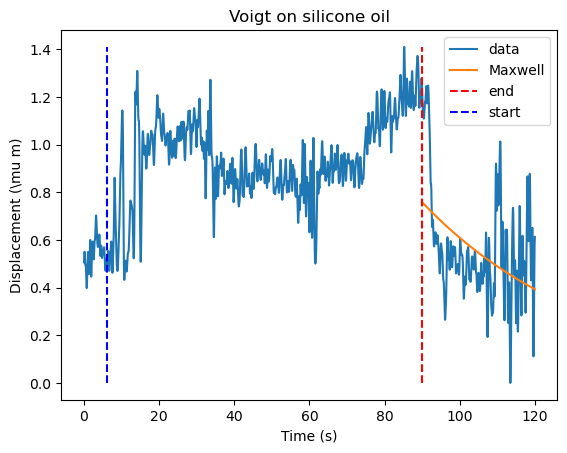

In [172]:
start_rel = end_creep

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:], df_track["distance"][start_rel:], bounds=([0,0], [1e3, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel,*p), label = "Maxwell")

print("Maxwell relaxation:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Voigt on silicone oil")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (\mu m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

plt.legend()
plt.show()

#plt.plot(df_current["offset"])

